<a href="https://colab.research.google.com/github/KarolChlasta/PJAIT-AdvancedML/blob/master/2.CNN/old_polish_cars-10classes_sota_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasyfikacja obrazu za pomocą konwolucyjnych sieci neuronowych

## Konfiguracja Old Polish Cars

In [0]:
# Put these at the top to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ torchvision==0.2.1.post2

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
     |████████████████████████████████| 61kB 9.0MB/s 
  Found existing installation: torchvision 0.4.2
    Uninstalling torchvision-0.4.2:
      Successfully uninstalled torchvision-0.4.2


In [3]:
!pip install torch torchvision fastai==0.6

     |████████████████████████████████| 430kB 30.9MB/s 
     |████████████████████████████████| 2.7MB 51.2MB/s 
     |████████████████████████████████| 1.5MB 51.7MB/s 
     |████████████████████████████████| 20.9MB 151kB/s 
     |████████████████████████████████| 5.9MB 54.3MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 481kB 56.9MB/s 
     |████████████████████████████████| 870kB 52.5MB/s 
     |████████████████████████████████| 81kB 14.0MB/s 
     |████████████████████████████████| 112kB 71.3MB/s 
     |████████████████████████████████| 51kB 9.8MB/s 
     |████████████████████████████████| 112kB 80.8MB/s 
  Created wheel for fastai: filename=fastai-0.6-cp36-none-any.whl size=69788 sha256=44011518c7ff994cd2387701af5db5dfb7365e431994c5968f5b310a1b350b32
  Stored in directory: /root/.cache/pip/wheels/98/2b/88/fe4cfe5bfa9cfea91cdfd2fe205f88746bf103f7b2994dffba
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl s

In [4]:
!pip install torch torchvision fastai==0.7.0

[autoreload of rsa.key failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'b'
]


     |████████████████████████████████| 122kB 31.2MB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: fastai 0.6
    Uninstalling fastai-0.6:
      Successfully uninstalled fastai-0.6


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pathlib import Path
import os

def download_and_save(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  # fetch file
  downloaded.FetchContent()
  # write file
  with open(file_name,'wb') as f:
       f.write(downloaded.content.read())
      
  print(f'Saved {file_name}')
  
FILE_NAME, FILE_ID = ['file_name', 'file_id']

### Pobierz zbiory danych

In [6]:
dataset_path = Path('/content/data/old_polish_cars'); dataset_path
!mkdir -p $dataset_path
!ls -la $dataset_path

total 8
drwxr-xr-x 2 root root 4096 Dec 28 14:32 .
drwxr-xr-x 3 root root 4096 Dec 28 14:32 ..


###  old_polish_cars_v5-split dataset

In [7]:
# old_polish_cars_v5_photos-512-split.tgz, https://drive.google.com/open?id=1kq3odh47lAAOK8MmeckHeCh1pTk6ga0i
old_polish_cars_v5_split = {FILE_NAME: 'old_polish_cars_v5_photos-512-split.tgz', FILE_ID: '1kq3odh47lAAOK8MmeckHeCh1pTk6ga0i'}
old_polish_cars_v5_split_path = dataset_path / old_polish_cars_v5_split[FILE_NAME]
download_and_save(old_polish_cars_v5_split_path, old_polish_cars_v5_split[FILE_ID])

Saved /content/data/old_polish_cars/old_polish_cars_v5_photos-512-split.tgz


In [0]:
# unpack
!tar -xf $old_polish_cars_v5_split_path -C $dataset_path

## Załadowanie bibliotek

In [9]:
!ln -s /content/plots_wcz.py /content/fastai/fastai/plots_wcz.py
!ln -s /content/imports_wcz.py /content/fastai/fastai/imports_wcz.py
!ln -s /content/model_wcz.py /content/fastai/fastai/model_wcz.py
!cd /content/fastai

ln: failed to create symbolic link '/content/fastai/fastai/plots_wcz.py': No such file or directory
ln: failed to create symbolic link '/content/fastai/fastai/imports_wcz.py': No such file or directory
ln: failed to create symbolic link '/content/fastai/fastai/model_wcz.py': No such file or directory
/bin/bash: line 0: cd: /content/fastai: No such file or directory


In [0]:
# Umieść je na górze każdego notatnika, aby uzyskać automatyczne ponowne ładowanie
%reload_ext autoreload
%autoreload 2

#matplotlib setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('seaborn-ticks')
# %config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import shutil as sh

# Ten plik zawiera wszystkie główne biblioteki zewnętrzne, których użyjemy
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Proste kroki do wytrenowania światowej klasy klasyfikatora obrazu

1. Włącz augmentację danych oraz cache aktywacji (precompute=True)
1. Użyj `lr_find()`, aby znaleźć najwyższe tempo uczenia się, przy którym strata (loss) jeszcze maleje
1. Trenuj ostatnią warstwę na cache'owanych aktywacjach przez 1-2 epoki
1. Trenuj ostatnią warstwę z augmentacją danych (tj. precompute=False) przez 2-3 epoki z cycle_len=1
1. Odblokuj wszystkie warstwy, używając `unfreeze()`
1. Ustaw dla wcześniejszych warstw 3x-10x mniejsze tempo uczenia się niż dla kolejnych wyższych warstw
1. Ponownie użyj `lr_find()`
1. Trenuj całą sieć z cycle_mult=2 aż do przetrenowania (over-fitting)

## Idea strojenia wytrenowanej sieci (fine-tuning)

`ConvLearner.pretrained` buduje *ucznia*, który zawiera wcześniej wytrenowany model. Ostatnia warstwa modelu musi zostać zastąpiona warstwą odpowiednich wymiarów. Ten model został wytrenowany dla 1000 klas, a ostateczna warstwa prognozuje wektor z 1000-cem prawdopodobieństw. Model dla old polish cars musi oddać wektor dwuwymiarowy. Poniższy schemat pokazuje na przykładzie, w jaki sposób zostało to zrobione w jednej z najwcześniej odnoszących sukces sieci konwolucyjnych CNN. Warstwa "FC8" zostanie tutaj zastąpiona nową warstwą z 10 wyjściami.

<img src="https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

Uczymy się *parametrów* poprzez dopasowanie modelu do danych. *Hiperparametr* to inny rodzaj parametru, którego nie można bezpośrednio nauczyć się ze zwykłego procesu treningowego. Parametry te wyrażają właściwości modelu "wyższego poziomu", takie jak jego złożoność, czy jak szybko ma się uczyć. Dwa przykłady hiperparametrów to *tempo uczenia się* i *liczba epok*.

Podczas iteracyjnego trenowania sieci neuronowej, *wsad (batch)* lub *mini-wsad (mini-batch)* jest podzbiorem treningowych próbek użytych w jednej iteracji metody stochastycznego gradientu prostego, ang. Stochastic Gradient Descent (SGD). *Epoka* to pojedyncze przejście przez cały zestaw treningowy, na nią składa się wiele iteracji SGD.

Możemy teraz *dopasować (fit)* model; to znaczy, użyć *metody gradientu prostego (gradient descent)*, aby znaleźć najlepsze parametry dla *w pełni połączonej warstwy (fully connected layer - FC)*, którą dodaliśmy, aby oddzielać zdjęcia marek samochodów od siebie. Musimy podać dwa hipertermery: *tempo uczenia się (learning rate)* (zazwyczaj 1e-2 lub 1e-3 jest dobrym punktem wyjścia, później przyjrzymy się temu bliżej) i *liczbę epok* (możesz podać większą liczbę i po prostu przerwij trening, gdy zauważysz, że dokładność (accuracy) już się nie poprawia, a następnie uruchom ponownie trening z liczbą epok, którą ustaliłeś).

## Mój dataset: 'Old Polish Cars v5'

Tym razem wytrenujemy model, który pozwoli rozróżnić 10 marek starych polskich samochodów. Dostępne jest 7300 oznakowanych zdjęć samochodów do trenowania i 800 w zestawie testowym, które musimy spróbować oznakować.

In [0]:
PATH = "/content/data/old_polish_cars/old_polish_cars_v5_photos-512-split/"

In [13]:
ls -lah /content/data/old_polish_cars

total 349M
drwxr-xr-x 3 root root  4.0K Dec 28 14:32 ./
drwxr-xr-x 3 root root  4.0K Dec 28 14:32 ../
drwxr-xr-x 4  501 staff 4.0K Jun  5  2018 old_polish_cars_v5_photos-512-split/
-rw-r--r-- 1 root root  349M Dec 28 14:32 old_polish_cars_v5_photos-512-split.tgz


## Sprawdzenie, czy dataset jest dostępny

In [14]:
!ls {PATH}

train  valid


In [15]:
!ls {PATH}valid

'Autobus Jelcz MZK'	'Fiat 126p Maluch'  'FSO Warszawa'  'ZSD Nysa'
'Autobus Jelcz Ogorek'	'FSC Zuk'	     Gazik
'Fiat 125p'		'FSO Polonez'	    'Syrena 105'


In [16]:
files = !ls {PATH}valid/"FSO Warszawa" | head
files

['15_1487453323.84.jpg',
 '21_1487453327.45.jpg',
 '32_1487453346.6_ddd.jpg',
 '33_1487453347.16_ddd_ddd.jpg',
 '44_1487453358.99_ddd.jpg',
 '46_1487453360.68_ddd.jpg',
 '48_1487453364.29_ddd_ddd.jpg',
 '56_1487453384.48_ddd_ddd.jpg',
 '63_1487453393.01_ddd_ddd.jpg',
 '67_1487453399.4.jpg']

In [17]:
files[9]

'67_1487453399.4.jpg'

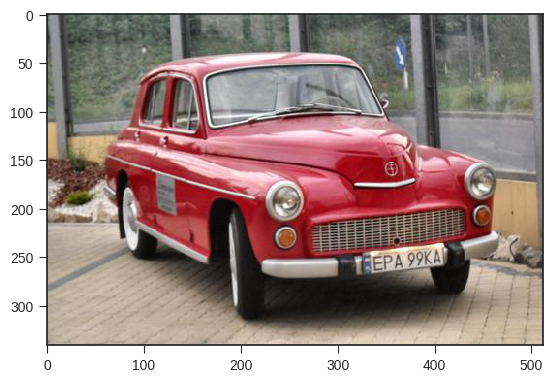

In [18]:
img = plt.imread(f'{PATH}valid/FSO Warszawa/{files[7]}')
plt.imshow(img);

## Trenowanie klasyfikatora

## 1) Włącz augmentację danych oraz cache aktywacji

augmentacja danych: `aug_tfms=transforms_side_on, max_zoom=1.1`

cache aktywacji: `precompute=True`

In [19]:
sz=224  # sz=128
arch=resnet34

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 26.3MB/s]


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


## 2) Znajdź tempo uczenia się

*Tempo uczenia się* określa, jak szybko lub jak wolno chcesz aktualizować *wagi* (lub *parametry*). Tempo uczenia się jest jednym z najtrudniejszych parametrów do ustawienia, ponieważ ma znaczący wpływ na wydajność modelu.

Metoda `learn.lr_find()` pomaga znaleźć optymalne tempo uczenia się. Wykorzystuje technikę opracowaną w 2015 roku, opisaną w publikacji [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), gdzie po prostu ciągle zwiększamy tempo uczenia się, zaczynając od bardzo małej wartości, kończąc kiedy strata przestaje maleć. Możemy stworzyć wykres tempa uczenia się poprzez wszystkie porcje danych jednej epoki, aby zobaczyć, jak to wygląda.

Najpierw tworzymy nowego ucznia `learn`, ponieważ chcemy wiedzieć, jak ustawić tempo uczenia się dla nowego (niewytrenowanego) modelu.

In [20]:
lrf = learn.lr_find()

 79%|███████▉  | 109/138 [00:01<00:00, 64.99it/s, loss=9.02]


Nasz obiekt `learn` ma atrybut `sched`, który zawiera naszego 'planistę' szybkości uczenia się i ma kilka przydatnych wykresów, w tym:



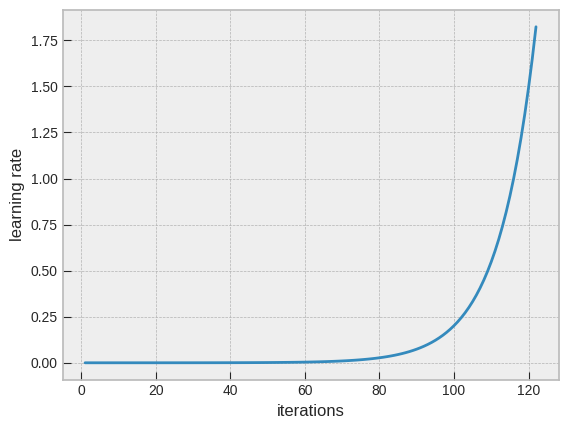

In [21]:
mpl.style.use('bmh')
learn.sched.plot_lr()

Zauważ, że na poprzednim wykresie jedna *iteracja* to iteracja (lub 'mini-batch') algorytmu SGD. W jednej epoce mamy `num_batch_samples/num_samples` iteracji SGD.

Możemy rzucić okiem wykres straty (loss) w stosunku do tempa uczenia się (learning rate), aby zobaczyć, gdzie zmniejsza się nasza strata:

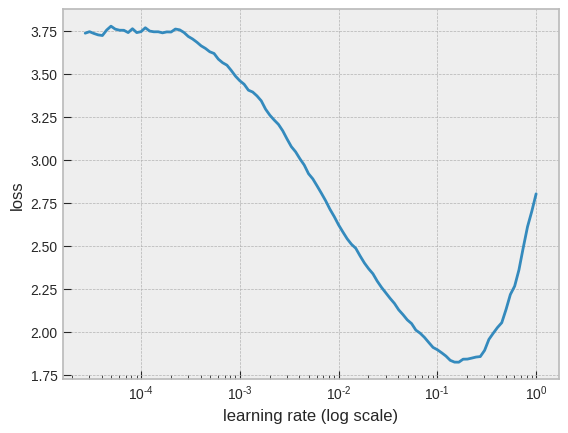

In [22]:
learn.sched.plot()

Strata wciąż wyraźnie maleje dla `lr=1e-2 (0.01)`, więc tego użyjemy. Zwróć uwagę, że optymalne tempo uczenia się może się zmieniać podczas treningu modelu, więc możesz chcieć ponownie uruchomić tę funkcję co jakiś czas.

wybrany lr=0.08

In [23]:
0.8*10**-1

0.08000000000000002

## 3) Wstępnie wytrenuj ostatnią warstwę
Trenuj ostatnią warstwę na cache'owanych aktywacjach przez 1-2 epoki.

Domyślnie, gdy tworzymy ucznia (`learn`), ustawia on wszystkie oprócz ostatniej warstwy na *zamrożone* (ang. frozen). Oznacza to, że kiedy wywołujemy `fit()`, uczeń aktualizuje wagi tylko w ostatniej warstwie.

In [24]:
learn.metrics = []
learn.fit(0.008, 3)  # stałe tempo uczenia się

epoch      trn_loss   val_loss   
    0      0.712945   0.415382  
    1      0.462797   0.383883  
    2      0.378265   0.328101  



[0.3281006571893789]

In [0]:
learn.save('224_initial')

In [0]:
learn.load('224_initial')

## 4) Trenuj ostatnią warstwę z augmentacją danych i wyżarzanie tempa uczenia się

### Augmentacja danych

Jeśli spróbujesz trenować przez więcej epok, zauważysz, że zaczynamy *przetrenowywać*, co oznacza, że nasz model uczy się rozpoznawać konkretne obrazy w zbiorze treningowym, zamiast generalizować tak, że uzyskamy dobre wyniki również na zestawie walidacyjnym. Jednym ze sposobów rozwiązania tego problemu jest faktyczne stworzenie większej ilości danych, dzięki *augmentacji danych*. Chodzi o losową modyfikację obrazów w sposób, który nie powinien wpływać na ich interpretację, takich jak poziome odbijanie, powiększanie i obracanie.

Możemy to zrobić, przekazując `aug_tfms` (*augmentation transforms*) do `tfms_from_model()`, z listą funkcji do zastosowania, które losowo zmieniają obraz, jak tylko chcemy. W przypadku zdjęć, które są w dużej mierze robione z boku (np. większość zdjęć samochodów, w przeciwieństwie do zdjęć zrobionych od góry, takich jak zdjęcia satelitarne), możemy użyć wstępnie zdefiniowanej listy funkcji `transforms_side_on`. Możemy również określić losowe powiększanie obrazów do określonej skali, dodając parametr `max_zoom`.

In [0]:
# tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [28]:
# transformers for training
tfms[0].tfms

In [29]:
# transformers for validation
tfms[1].tfms

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

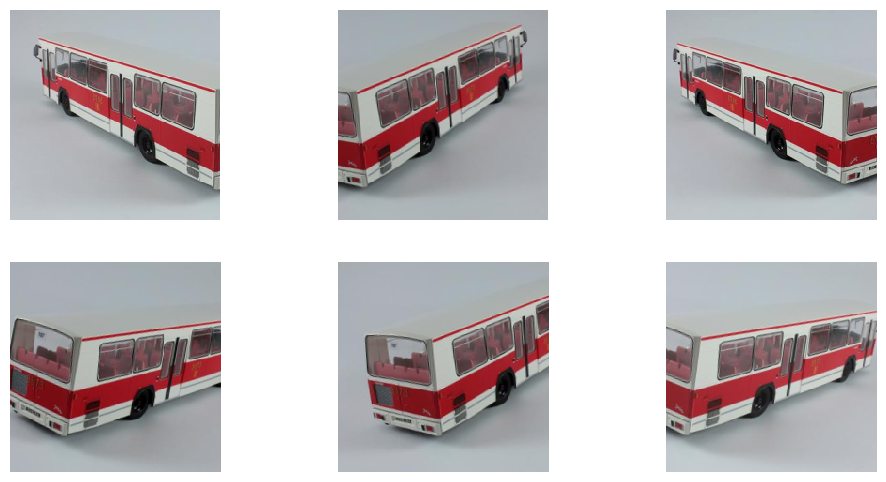

In [32]:
plots(ims, rows=2)

Trenuj ostatnią warstwę z augmentacją danych (tj. `precompute=False`) przez 2-3 epoki z `cycle_len=1`

In [33]:
learn.precompute=False  # użyj augmentacji danych
learn.fit(0.08, 3, cycle_len=1)

epoch      trn_loss   val_loss   
    0      1.140017   0.397697  
    1      0.834634   0.387606  
    2      0.686402   0.302403  



[0.3024033950299633]

### Metoda stochastycznego gradientu prostego z restartami

Co to jest parametr `cycle_len`? To, co tutaj robimy, to metoda *stochastycznego gradientu prostego z restartami (ang. stochastic gradient descent with restarts - SGDR)*, jest to wariant *hartowania szybkości uczenia (ang. learning rate annealing)*, która stopniowo zmniejsza tempo uczenia się w miarę postępu treningu. To pomaga, bo gdy zbliżamy się do optymalnych wag, chcemy podejść tam mniejszymi krokami.

Jednakże możemy znaleźć się w części przestrzeni wag, która nie jest bardzo odporna - to znaczy niewielkie zmiany wag mogą spowodować duże zmiany w stracie. Chcemy zachęcić nasz model do znalezienia części przestrzeni wag, które są zarówno dokładne, jak i stabilne. Dlatego od czasu do czasu zwiększamy szybkość uczenia się (jest to "restart" w "SGDR"), co zmusi model do przejścia do innej części przestrzeni wag, jeśli obecny obszar jest "spiczasty". Oto wykres tego, jak to może wyglądać, jeśli zresetujemy tempo uczenia się 3 razy (w tej publikacji nazywają to "cyklicznym harmonogramem LR", ang. 'cyclic LR schedule'):

![SGDR](https://raw.githubusercontent.com/fastai/fastai/master/courses/dl1/images/sgdr.png)
(Z publikacji [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

Liczba epok pomiędzy resetowaniem tempa uczenia się jest ustalana przez `cycle_len`, a liczba razy, kiedy to się dzieje, jest określana jako *liczba cykli*, i jest tym, co faktycznie przekazujemy jako drugi parametr do `fit()`. Oto jak wyglądało nasze rzeczywiste tempo uczenia się:

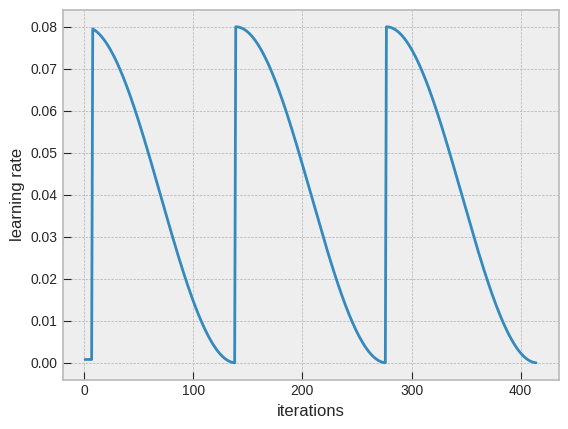

In [34]:
learn.sched.plot_lr()

Nasza strata na zestawie walidacyjnym nie ulega znacznej poprawie, więc prawdopodobnie nie ma potrzeby dalszego trenowania samej ostatniej warstwy.

Ponieważ w tym momencie mamy już całkiem niezły model, możemy chcieć go zapisać, abyśmy mogli go załadować ponownie później bez trenowania od początku.

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

## 5) Dostrój (fine-tune) wcześniejsze warstwy i 6) różnicowo hartuj tempa uczenia się
Odblokuj wszystkie warstwy, używając `unfreeze()`.<br/>
Ustaw dla wcześniejszych warstw 3x-10x mniejsze tempo uczenia się niż dla kolejnych wyższych warstw.

Teraz, gdy mamy już wytrenowaną dobrą warstwę końcową, możemy spróbować dostroić pozostałe warstwy. Aby powiedzieć uczniowi, że chcemy odblokować pozostałe warstwy, wystarczy użyć `unfreeze()`.

In [0]:
learn.unfreeze()

Zauważ, że pozostałe warstwy zostały *już wcześniej* wytrenowane do rozpoznawania zdjęć imagenetowych (podczas gdy nasze końcowe warstwy zostały losowo zainicjowane), więc chcemy zadbać o to, aby nie zniszczyć dokładnie wyregulowanych wag, które już tam są.

Ogólnie mówiąc, wcześniejsze warstwy (jak już widzieliśmy) mają funkcje działające bardziej ogólnie. Dlatego spodziewamy się, że będą potrzebowały mniejszego dostrojenia dla nowego zestawu danych. Z tego powodu użyjemy różnych temp uczenia się dla różnych warstw: pierwsze kilka warstw będzie na poziomie 1e-4, środkowe warstwy na 1e-3, a nasze warstwy FC pozostawimy na 1e-2, tak jak poprzednio. Nazywamy to *zróżnicowanymi tempami uczenia się* ang. "differential learning rates", chociaż, o ile nam wiadomo, nie ma standardowej nazwy dla tej technologii w literaturze.

In [38]:
lr = np.array([0.0008, 0.008, 0.08])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.494614   0.176653  
    1      0.268855   0.128491  
    2      0.113603   0.081099  
    3      0.126884   0.070219  
    4      0.067586   0.065087  
    5      0.041572   0.049202  
    6      0.037904   0.046388  



[0.046388423442840575]

Kolejną sztuczką, której tutaj użyliśmy jest dodanie parametru `cycle_mult`. 

Rzuć okiem na poniższy wykres i sprawdź, czy dojdziesz, co ten parametr robi:

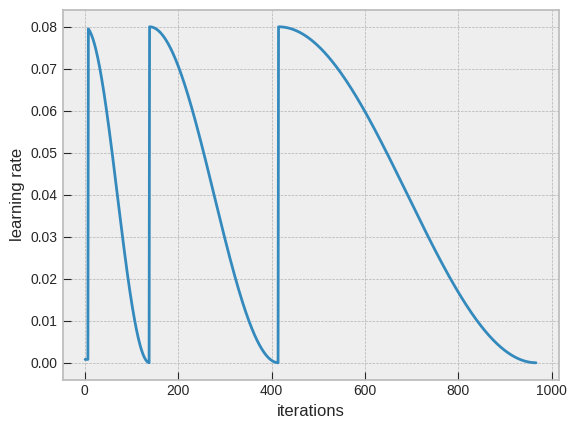

In [39]:
learn.sched.plot_lr()

Zauważ, że to, co wykreślono powyżej, to tempo uczenia się *ostatnich warstw*. Współczynniki uczenia się wcześniejszych warstw są ustalane na mnożnikach względem wybranego wcześniej tempa dla ostatnich warstw (tj. pierwsze warstwy mają 100x mniejsze, a warstwy średnie 10x mniejsze tempo uczenia się, skoro ustawiamy `lr=np.array([1e-4,1e-3,1e-2])`.

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

## 7) Ponownie użyj lr_find()

In [42]:
lrf = learn.lr_find()

 62%|██████▏   | 86/138 [00:56<00:39,  1.31it/s, loss=0.104] 

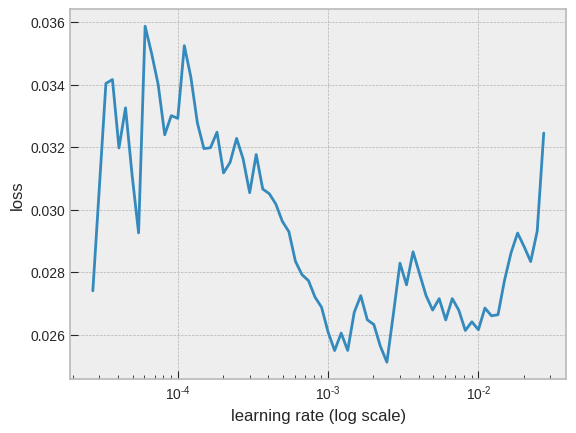

In [43]:
learn.sched.plot()

In [0]:
lr = np.array([0.00001, 0.0001, 0.001])

## 8) Trenuj całą sieć z cycle_mult=2 aż do przetrenowania (over-fitting)

In [45]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.032847   0.044585  
    1      0.034726   0.044283  
    2      0.033358   0.045804  
    3      0.025636   0.044115  
    4      0.027695   0.044226  
    5      0.023652   0.043754  
    6      0.032513   0.04507   


[0.04507015116360723]

In [0]:
learn.save('224_final')

In [0]:
learn.load('224_final')

# Kontrola jakości na zestawie walidacyjnym

### Prognoza z użyciem TTA (Test Time Augmentation)

Jest jeszcze coś, co możemy zrobić z augmentacją danych: użyj jej podczas *wnioskowania* (czy *testowania*). Nic dziwnego, że jest to znane jako *augmentacja podczas testowania*, ang. "test time augmentation" lub po prostu *TTA*.

TTA po prostu tworzy prognozy nie tylko na obrazach z twojego zbioru walidacyjnego, ale także tworzy prognozy dla pewnej liczby losowo augmentowanych ich wersji (domyślnie używa oryginalnego obrazu wraz z 4 losowo augmentowanymi wersjami). Następnie liczy i używa średniej prognozy z tych obrazów. Aby użyć TTA na zestawie walidacyjnym, możemy skorzystać z metody `TTA()` ucznia.

In [48]:
log_preds_tta, y_tta = learn.TTA()

In [0]:
probs_tta = np.mean(np.exp(log_preds_tta),0)
preds_tta = np.argmax(probs_tta, axis=1)  # from log probabilities to 0 or 1

In [50]:
probs_tta[0:3, :]

array([[1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.999  , 0.0001 , 0.00041, 0.00001, 0.     , 0.00001, 0.     , 0.     , 0.     , 0.00047]],
      dtype=float32)

In [0]:
# preds_tta[:3]

In [52]:
accuracy_np(probs_tta, y_tta)

0.986734693877551

Zwykle widać 10-20 procentowy spadek błędu na tym zestawie danych podczas korzystania z TTA w tym momencie, co jest niesamowitym wynikiem dla tak szybkiej i prostej techniki!

### Prognoza bez TTA

In [0]:
# to tworzy prognozę dla zestawu walidacyjnego. Prognozy są w skali logarytmicznej
log_preds = learn.predict()
y = data.val_y

In [0]:
preds = np.argmax(log_preds, axis=1)  # od logarytmu prawdopodobieństwa do 0, 1, ... lub 9
probs = np.exp(log_preds);            # pr(car)

In [55]:
probs[0:3, :]

array([[1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.99999, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.00001]],
      dtype=float32)

In [56]:
preds[:150]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1])

In [57]:
print('preds: ', len(preds), preds[0:10], '\nprobs: ', len(probs), probs[0:10])

preds:  980 [0 0 0 0 0 0 0 0 0 0] 
probs:  980 [[1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [0.99999 0.      0.      0.      0.      0.      0.      0.      0.      0.00001]
 [1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]
 [1.      0.      0.      0.      0.      0.      0.      0.      0.      0.     ]]


In [58]:
accuracy_np(probs, y)

0.9908163265306122

## Analiza wyników - tablica pomyłek

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
# use to check TTA predictions
# y = y_tta
# preds = preds_tta

[[97  0  0  0  0  0  0  0  0  1]
 [ 0 95  0  0  0  0  0  0  0  3]
 [ 0  0 98  0  0  0  0  0  0  0]
 [ 0  0  0 97  0  0  1  0  0  0]
 [ 0  0  0  0 98  0  0  0  0  0]
 [ 0  0  0  0  0 97  1  0  0  0]
 [ 0  0  0  0  0  0 98  0  0  0]
 [ 0  0  0  0  0  0  0 98  0  0]
 [ 0  0  0  0  1  0  0  0 96  1]
 [ 0  0  0  0  0  1  0  0  0 97]]


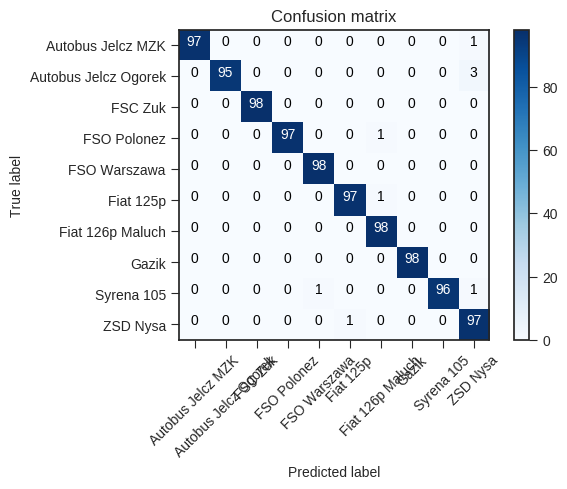

In [61]:
cm = confusion_matrix(y, preds)

mpl.style.use('default')
mpl.style.use('seaborn-ticks')
plot_confusion_matrix(cm, data.classes)

# Koniec

## Opcjonalnie

### Dane (old_polish_cars_v5)

In [62]:
# old_polish_cars_v5_photos-512.tgz, https://drive.google.com/open?id=1q0O5cOgzg8R65nnMAQehviJVU45CwOJ8
old_polish_cars_v5 = {FILE_NAME: 'old_polish_cars_v5_photos-512.tgz', FILE_ID: '1q0O5cOgzg8R65nnMAQehviJVU45CwOJ8'}
old_polish_cars_v5_path = dataset_path / old_polish_cars_v5[FILE_NAME]
download_and_save(old_polish_cars_v5_path, old_polish_cars_v5[FILE_ID])

Saved /content/data/old_polish_cars/old_polish_cars_v5_photos-512.tgz


In [0]:
# unpack
!tar -xf $old_polish_cars_v5_path -C $dataset_path

### Dane (old_polish_cars_v4)

In [64]:
# old_polish_cars_v4_photos-512.tgz, https://drive.google.com/open?id=1awht15dL2t3G4e8HWKwIyad0MebpdcgI
old_polish_cars_v4 = {FILE_NAME: 'old_polish_cars_v4_photos-512.tgz', FILE_ID: '1awht15dL2t3G4e8HWKwIyad0MebpdcgI'}
old_polish_cars_v4_path = dataset_path / old_polish_cars_v4[FILE_NAME]

download_and_save(old_polish_cars_v4_path, old_polish_cars_v4[FILE_ID])

Saved /content/data/old_polish_cars/old_polish_cars_v4_photos-512.tgz


In [0]:
# unpack

!tar -xf $old_polish_cars_v4_path -C $dataset_path

### Modele

In [0]:
models_path = dataset_path / 'old_polish_cars_v5_photos-512-split/models'
!mkdir -p $models_path

In [67]:
# 224_lastlayer.h5, https://drive.google.com/open?id=1avcGo8__1eMTjXMwQT8atKrQLel75hHm
m224_lastlayer = {FILE_NAME: '224_lastlayer.h5', FILE_ID: '1avcGo8__1eMTjXMwQT8atKrQLel75hHm'}
download_and_save(models_path / m224_lastlayer[FILE_NAME], m224_lastlayer[FILE_ID])

Saved /content/data/old_polish_cars/old_polish_cars_v5_photos-512-split/models/224_lastlayer.h5


In [68]:
# 224_all.h5, https://drive.google.com/open?id=17qRBfyG96SW2uO2WIwhdhMk44-pW8HmO
m224_all = {FILE_NAME: '224_all.h5', FILE_ID: '17qRBfyG96SW2uO2WIwhdhMk44-pW8HmO'}
download_and_save(models_path / m224_all[FILE_NAME], m224_all[FILE_ID])

Saved /content/data/old_polish_cars/old_polish_cars_v5_photos-512-split/models/224_all.h5


In [69]:
ls -lah $dataset_path

total 987M
drwxr-xr-x  5 root root  4.0K Dec 28 15:02 ./
drwxr-xr-x  3 root root  4.0K Dec 28 14:32 ../
drwx------ 12  501 staff 4.0K Mar 14  2017 old_polish_cars_v4_photos-512/
-rw-r--r--  1 root root  347M Dec 28 15:01 old_polish_cars_v4_photos-512.tgz
drwxr-xr-x 12  501 staff 4.0K Apr  8  2018 old_polish_cars_v5_photos-512/
drwxr-xr-x  6  501 staff 4.0K Dec 28 14:33 old_polish_cars_v5_photos-512-split/
-rw-r--r--  1 root root  349M Dec 28 14:32 old_polish_cars_v5_photos-512-split.tgz
-rw-r--r--  1 root root  291M Dec 28 15:01 old_polish_cars_v5_photos-512.tgz


In [70]:
ls -lah $models_path

total 336M
drwxr-xr-x 2 root root  4.0K Dec 28 15:00 ./
drwxr-xr-x 6  501 staff 4.0K Dec 28 14:33 ../
-rw-r--r-- 1 root root   84M Dec 28 15:02 224_all.h5
-rw-r--r-- 1 root root   84M Dec 28 15:00 224_final.h5
-rw-r--r-- 1 root root  2.1M Dec 28 14:34 224_initial.h5
-rw-r--r-- 1 root root   84M Dec 28 15:02 224_lastlayer.h5
-rw-r--r-- 1 root root   84M Dec 28 14:49 tmp.h5


### Integracja z Google Drive

In [71]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

### Monitoring

In [72]:
ls -lh

total 64K
-rw-r--r-- 1 root root 2.7K Dec 28 14:32 adc.json
drwxr-xr-x 3 root root 4.0K Dec 28 14:32 data/
drwxr-xr-x 2 root root 4.0K Dec 28 15:09 drive/
-rw-r--r-- 1 root root  45K Dec 28 14:49 lr_plot.png
drwxr-xr-x 1 root root 4.0K Dec 18 16:52 sample_data/


In [73]:
who

A	 AdaptiveConcatPool2d	 AddPadding	 ArraysDataset	 ArraysIndexDataset	 ArraysNhotDataset	 BaseDataset	 BasicBlock	 BasicModel	 
Bottleneck	 BottleneckFinal	 BottleneckZero	 Callback	 CenterCrop	 ChannelOrder	 CircularLR	 CircularLR_beta	 Compose	 
ConvLearner	 ConvnetBuilder	 CoordTransform	 CosAnneal	 Counter	 CropType	 Cutout	 DataFrameSummary	 DataLoader	 
Dataset	 DecayScheduler	 DecayType	 Denormalize	 F	 FILE_ID	 FILE_NAME	 FP16	 FileLink	 
FilesArrayDataset	 FilesDataset	 FilesIndexArrayDataset	 FilesIndexArrayRegressionDataset	 FilesNhotArrayDataset	 Flatten	 FloatTensor	 GoogleAuth	 GoogleCredentials	 
GoogleDrive	 GoogleNetResize	 IPKernelApp	 IPython	 IS_TORCH_04	 Image	 ImageClassifierData	 ImageData	 ImageEnhance	 
ImageModelResults	 ImageOps	 InceptionResnetV2	 IntEnum	 IterBatch	 Iterable	 LR_Finder	 LR_Finder2	 LR_Updater	 
Lambda	 LayerOptimizer	 Learner	 LoggingCallback	 LongTensor	 LooseVersion	 LossRecorder	 ModelData	 NoCrop	 
Normalize	 OptimScheduler	 OrderedDic

In [74]:
!uptime

 15:09:58 up 44 min,  0 users,  load average: 0.00, 1.20, 3.19


In [75]:
cd fastai

[Errno 2] No such file or directory: 'fastai'
/content


In [76]:
!/opt/bin/nvidia-smi

Sat Dec 28 15:10:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    25W /  75W |   3371MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [77]:
for i in range(3):
  !top -n 1

=top - 15:10:05 up 44 min,  0 users,  load average: 0.00, 1.18, 3.17
Tasks:   7 total,   1 running,   6 sleeping,   0 stopped,   0 zombie
%Cpu(s): 51.5 us,  8.2 sy,  0.0 ni, 39.2 id,  1.1 wa,  0.0 hi,  0.1 si,  0.0 st
KiB Mem : 13335188 total,   248092 free,  3964208 used,  9122888 buff/cache
KiB Swap:        0 total,        0 free,        0 used. 11301692 avail Mem 

    PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND   
      8 root      20   0  693904  59024  25140 S   6.7  0.4   0:06.70 node      
     18 root      20   0  414960 110560  25952 S   6.7  0.8   0:15.33 jupyter-+ 
   3034 root      20   0   63180   6692   4968 R   6.7  0.1   0:00.03 top       
      1 root      20   0   39192   6444   4940 S   0.0  0.0   0:00.03 run.sh    
    115 root      20   0   35888   4908   3812 S   0.0  0.0   0:00.11 tail      
    123 root      20   0 21.027g 3.660g 543060 S   0.0 28.8  47:18.88 python3   
   3013 root      20   0  196540  31060   9844 S   0.0  0.2  

In [78]:
!top -h

  procps-ng 3.3.12
Usage:
  top -hv | -bcHiOSs -d secs -n max -u|U user -p pid(s) -o field -w [cols]


In [79]:
import os
import psutil

def print_memsize():
  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss / 1024**3:.5} GB')
  
print_memsize()

3.6595 GB


In [80]:
print_memsize()
!lsb_release -a

3.6595 GB
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic
